In [20]:
import torch
from torch.utils.data import DataLoader, Dataset

import numpy as np
import random

In [21]:
batch_size = 32  # how many samples per batch to load
iid = 1 # if the data is i.i.d or not
unbalanced = 0 # in non i.i.d. setting split the data between clients equally or not
num_users = 100 # number of client

In [22]:
if iid:
    from utils_v2 import get_dataset, average_weights, exp_details
else:
    from utils import get_dataset, average_weights, exp_details

In [23]:
# for REPRODUCIBILITY https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(0)

g = torch.Generator()
g.manual_seed(0)

np.random.seed(0)

In [24]:
train_dataset, test_dataset, user_groups = get_dataset(iid=iid, unbalanced=unbalanced,
                                                       num_users=num_users)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
class DatasetSplit(Dataset):
    """
    An abstract Dataset class wrapped around Pytorch Dataset class.
    """

    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return torch.tensor(image), torch.tensor(label)

In [26]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [27]:
def get_dataloader(dataset, idxs):
    trainloader = DataLoader(DatasetSplit(dataset, idxs),
                             batch_size=batch_size, shuffle=True, generator=g,
                             worker_init_fn=seed_worker)

    return trainloader

In [28]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [29]:
user_lables = dict()
user_mean = dict()
user_std = dict()

for idx in user_groups.keys():
    labels_list = []
    #trainloader, _ = get_dataloader(train_dataset, user_groups[idx])
    trainloader = get_dataloader(train_dataset, user_groups[idx])
    mean = 0.0
    std = 0.0
    for data, target in trainloader:
        for i in range(len(data)):
            label = target.data[i]
            labels_list.append(classes[int(label)])

        # compute mean and std variation
        images = data.view(data.size(0), data.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(trainloader.dataset)
    std /= len(trainloader.dataset)

    user_mean[idx] = mean.numpy()
    user_std[idx] = std.numpy()

    user_lables[idx] = labels_list

C:\Users\david\AppData\Local\Temp\ipykernel_34036\3803027819.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image), torch.tensor(label)


In [30]:
user_std[0]

array([1.2430825, 1.2402743, 1.1949962], dtype=float32)

In [31]:
def count_labels(user_labels, classes):
    user_labels_count = dict()
    for idx in user_groups.keys():
        elements_count = {}
        # iterating over the elements for frequency
        for element in user_labels[idx]:
            # checking whether it is in the dict or not
            if element in elements_count:
                # incerementing the count by 1
                elements_count[element] += 1
            else:
                # setting the count to 1
                elements_count[element] = 1

        user_labels_count[idx] = elements_count

    return user_labels_count

user_labels_count = count_labels(user_lables, classes)

In [32]:
import pandas as pd

data = pd.DataFrame.from_dict(user_labels_count, orient="index")

In [33]:
data.sum()

truck         5000
dog           5000
cat           5000
deer          5000
ship          5000
horse         5000
frog          5000
airplane      5000
automobile    5000
bird          5000
dtype: int64

In [34]:
data

,truck,dog,cat,deer,ship,horse,frog,airplane,automobile,bird
0,50,50,50,50,50,50,50,50,50,50
1,50,50,50,50,50,50,50,50,50,50
2,50,50,50,50,50,50,50,50,50,50
3,50,50,50,50,50,50,50,50,50,50
4,50,50,50,50,50,50,50,50,50,50
...,...,...,...,...,...,...,...,...,...,...
95,50,50,50,50,50,50,50,50,50,50
96,50,50,50,50,50,50,50,50,50,50
97,50,50,50,50,50,50,50,50,50,50
98,50,50,50,50,50,50,50,50,50,50


In [35]:
data.isna()

,truck,dog,cat,deer,ship,horse,frog,airplane,automobile,bird
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
95,False,False,False,False,False,False,False,False,False,False
96,False,False,False,False,False,False,False,False,False,False
97,False,False,False,False,False,False,False,False,False,False
98,False,False,False,False,False,False,False,False,False,False


In [36]:
class_each_user = [ (10 - data.isna().values[i].sum()) for i in range(len(data)) ]
print(np.mean(class_each_user))
print(np.std(class_each_user))

10.0
0.0


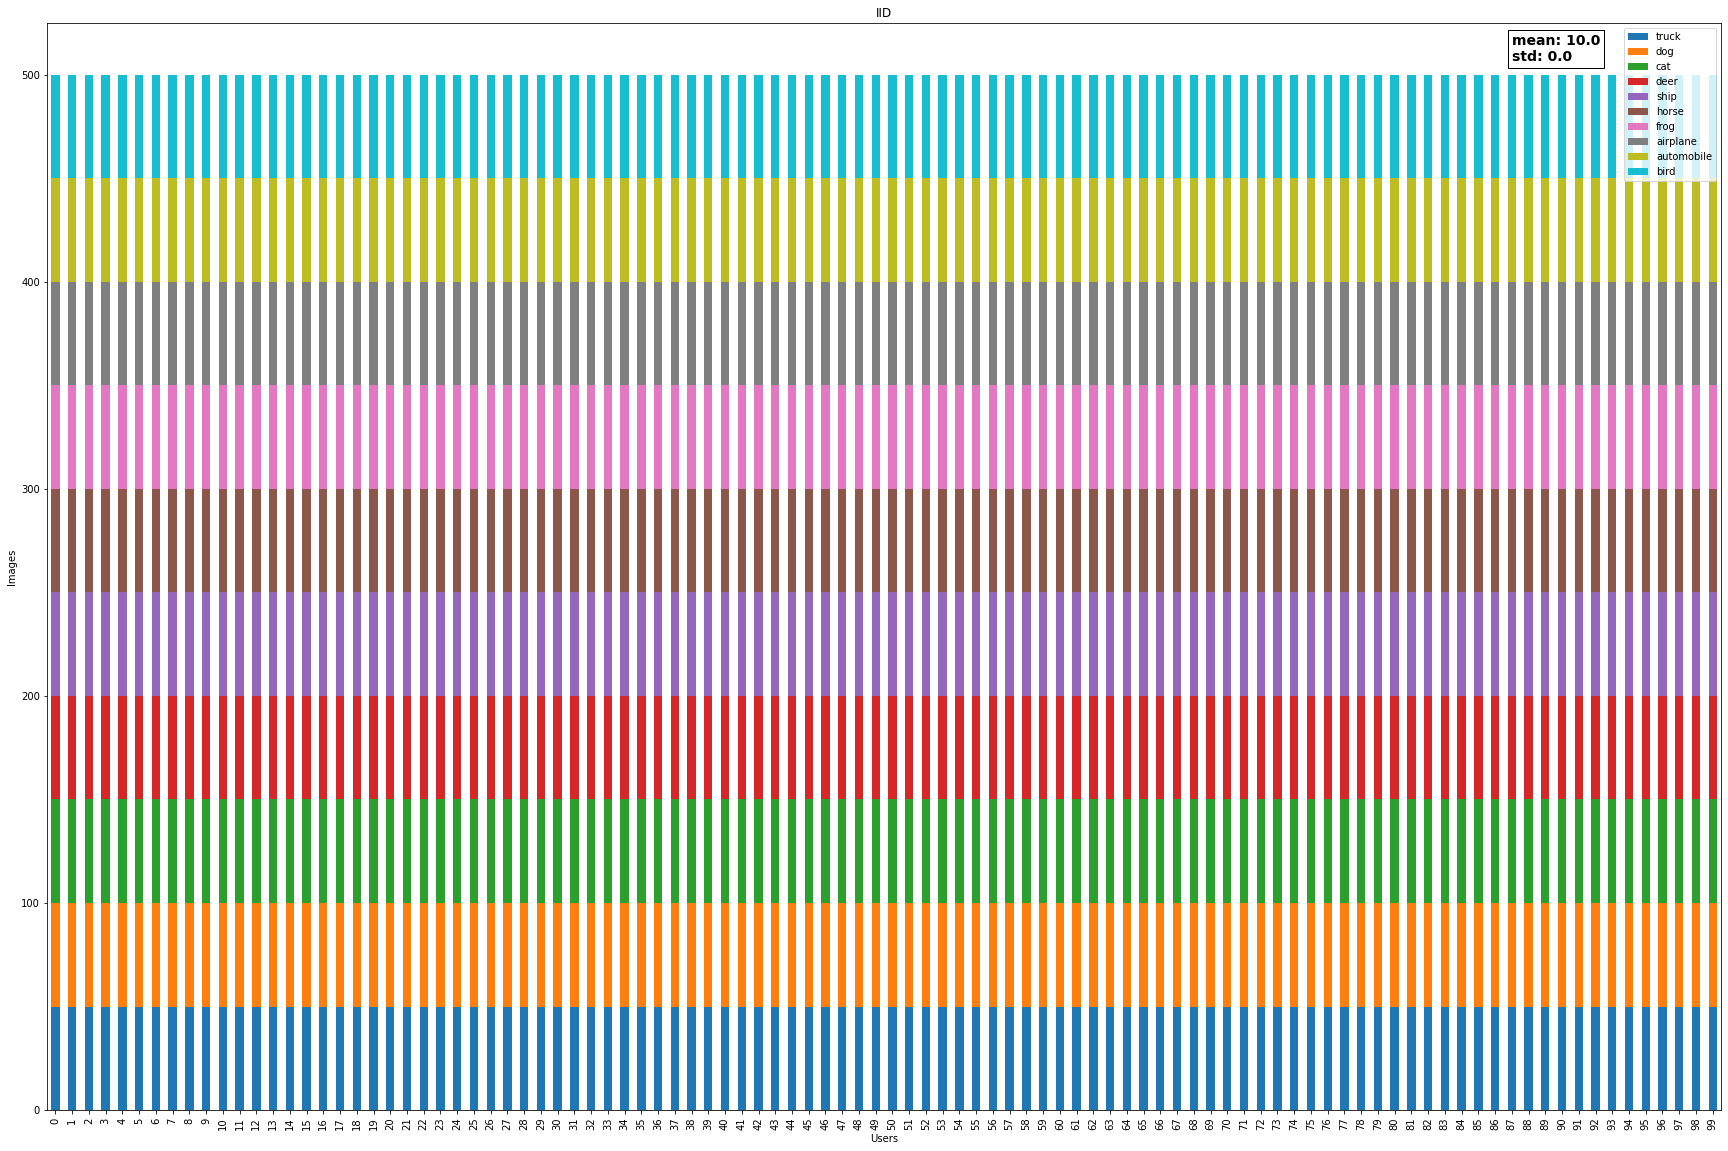

In [37]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(30, 20))

data.plot.bar(stacked=True, ax=ax)

plt.title("IID")
plt.ylabel('Images')
plt.xlabel('Users')

plt.annotate(f"mean: {np.mean(class_each_user).round(2)}\nstd: {np.std(class_each_user).round(2)}", xy=(0.875, 0.965), xycoords='axes fraction', weight="bold", size=14, bbox=dict(facecolor='none',boxstyle="square,pad=0.3"))

plt.savefig("data_distribution/IID.png")
# plt.savefig("data_distribution/new_random_seed/test.png")

In [38]:
images_each_user = [ len(user_groups[idx]) for idx in user_groups.keys() ]
print(np.mean(images_each_user))
print(np.std(images_each_user))

500.0
0.0
